In [1]:
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import NearestNeighbors
from time import time

In [2]:
NumTrials = 1

D = 3
dim = 2
tau = 1
sigma = 0.06

In [3]:
def manfit_ours(sample, sig, sample_init, op_average=1):
    Mout = np.copy(sample_init)
    N = sample_init.shape[0]
    N0 = sample.shape[0]
    ns = np.arange(1, N0 + 1)

    r = 5 * sig / np.log10(N0)
    R = 10 * sig * np.sqrt(np.log(1 / sig)) / np.log10(N0)

    for ii in range(N):
      
        x = sample_init[ii, :]

        dists = squareform(pdist(np.vstack([x, sample])))[0, 1:]

        IDX1 = dists < 2 * r
        IDX1 = ns[IDX1]

        nbrs = NearestNeighbors(n_neighbors=5).fit(sample)
        IDX2 = nbrs.kneighbors(x.reshape(1, -1), return_distance=False).flatten()

        IDX = np.union1d(IDX1, IDX2)

        BNbr = sample[IDX - 1, :]

        xbar = np.mean(BNbr, axis=0) + np.finfo(float).eps

        dx = x - xbar
        dx = dx / np.linalg.norm(dx)

        Q = np.linalg.qr(np.column_stack([dx, np.eye(dx.size)]))[0]

        sample_s = sample - x
        sample_s = sample_s @ Q

        CNbr = (np.abs(sample_s[:, 0]) < R) & (np.sum(sample_s[:, 1:] ** 2, axis=1) < r ** 2)

        if np.sum(CNbr) > 10:
            Mout[ii, :] = np.mean(sample[CNbr, :], axis=0)
        else:
            Mout[ii, :] = xbar

    return Mout

In [4]:
def torusUnif(n, R, r):
    # generate n samples uniformly from a torus
    # R : the radius from the center of the hole to the center of the torus tube
    # r : the radius of the torus tube. 
    #
    # There is an R package with the same name
    # Algorithm 1 of Diaconis P, Holmes S, and Shahshahani M (2013). "Sampling from a manifold." 
    # Advances in Modern Statistical Theory and Applications: A Festschrift in honor of Morris L. Eaton. 
    # Institute of Mathematical Statistics, 102-125.
    
    count = 0
    theta = -np.ones((1, n))
    
    while count < n:
        xvec = np.random.rand(1)*2*math.pi
        yvec = np.random.rand(1)/math.pi
        fx = (1 + r/R*math.cos(xvec))/(2*math.pi)
        if yvec < fx:
            theta[:, count] = xvec
            count = count + 1
    
    phi = np.random.rand(1, n)*2*math.pi
    x = (R + r*np.cos(theta))*np.cos(phi)
    y = (R + r*np.cos(theta))*np.sin(phi)
    z = r*np.sin(theta)

    X = np.vstack((x, y, z))
    
    return X

In [5]:
def pdtorus(R, r, X):
    
    # return the projection p of x onto the torus:
    #    {(a,b,c) | (R-sqrt(a^2+b^2))^2+c^2 = r^2}
    # d = ||p-x||_2
    #
    # xiayq @ 8/14/2019
    #
    # xiayq@zju.edu.cn
    # refered to Yao, Z and Xia, Y. (2019). Manifold Fitting under Unbounded Noise, arXiv:1909.10228
    
    temp1 = np.sqrt(X[0, :]**2 + X[1, :]**2)
    temp2 = R/temp1
    temp3 = (R - temp1)**2 + X[2, :]**2
    w1 = r/np.sqrt(temp3)
    w0 = temp2 + (1 - temp2)*w1
    
    P = X*np.vstack((w0, w0, w1))
    
    d = np.sqrt(sum((X - P)**2))
    
    return [P, d]


In [12]:
num_samples = 1000
num_ini = 1000
a = 2/3; b = 1/3; 

samples = torusUnif(num_samples, a, b)
samples = samples + sigma*np.random.randn(D, num_samples)

data_ini = torusUnif(2*num_ini, a, b)
data_ini = data_ini + 2*sigma / np.sqrt(D)*(2*np.random.rand(D, 2 * num_ini) - 1)
[proj_data_ini,d] = pdtorus(a, b,data_ini)

norm_n2 = np.sum((data_ini - proj_data_ini) ** 2, axis=0)
indices = np.argsort(norm_n2)[::-1]
data_ini = data_ini[:, indices[:num_ini]]


In [13]:
tic = time()
Mout = manfit_ours(samples.T, sigma, data_ini.T)
Mout = Mout.T
toc = time() - tic

(-0.8972279252765644,
 0.8632012834807773,
 -0.9291487907168446,
 0.9606667254114519)

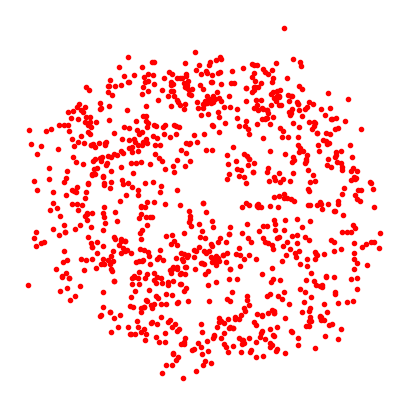

In [14]:
fig_width = 5  # Set the desired width in inches
fig_height = 5  # Set the desired height in inches
plt.figure(figsize=(fig_width, fig_height))
plt.plot(Mout[0, :], Mout[1, :], 'r.')
plt.box(False)
plt.axis('off')